In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [3]:
np.random.seed(2020)
K=10000
x1,x2,y = DGP(K)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}
$$

In [4]:
# creating the first column in X
one = [1]*K

# finding the transpose of x by vertically stacking one together with the data given
x_t = np.matrix(np.vstack((one,x1,x2)))

#finding x as the transpose of x_t
x = x_t.transpose()

#converting y to a column vector y1
y1=y[:, np.newaxis]

#computing the betas
beta=np.linalg.inv(x_t @ x) @ x_t @ y1

In [5]:
beta0_hat=float(beta[0])
beta1_hat=float(beta[1])
beta2_hat=float(beta[2])
print(f'the beta0_hat estimated with matrices is {float(beta[0]):.4f}')
print(f'the beta1_hat estimated with matrices is {float(beta[1]):.4f}')
print(f'the beta2_hat estimated with matrices is {float(beta[2]):.4f}')

the beta0_hat estimated with matrices is 0.0957
the beta1_hat estimated with matrices is 0.2929
the beta2_hat estimated with matrices is 0.5033


In [6]:
#we verify the solution with a lingalg built solver:
solution = np.linalg.lstsq(x,y1)

print(f'the estimated beta0_hat is {float(solution[0][0]):.4f}')
print(f'the estimated beta1_hat is {float(solution[0][1]):.4f}')
print(f'the estimated beta2_hat is {float(solution[0][2]):.4f}')

the estimated beta0_hat is 0.0957
the estimated beta1_hat is 0.2929
the estimated beta2_hat is 0.5033


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

In [7]:
# creating a function which finds the y_values predicted by the model as a function of the data
def y_hat(x1,x2):
    return beta0_hat + beta1_hat*x1 + beta2_hat*x2

In the following code we create a 3-dimensional plot. Please note the plot has to be dragged a little bit to be able to see the plane of the predicted values.


In [8]:
# creating grids for the plot 
x1_grid,x2_grid = np.meshgrid(x1,x2,indexing='ij')
y_grid = y_hat(x1_grid,x2_grid)

# creating the plot
%matplotlib widget
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,y_grid,cmap=cm.coolwarm,linewidth=0,alpha=0.1)
goldman_blue = '#64a8f0'
ax.scatter(x1,x2,y1,c=goldman_blue)

# adding labels
ax.set_xlabel('$x_{1,i}$', fontsize = 15)
ax.set_ylabel('$x_{2,i}$', fontsize = 15)
ax.set_zlabel('$\hat{y}_i$', fontsize = 15)

# inverting xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

plt.savefig('ols.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [9]:
# defining the residuals as a function of the parameters
u=np.empty(len(x1))
def residuals(y1,x1,x2,beta0,beta1,beta2):

    for i in range(len(x1)):
        u[i] = (y1[i] - beta0 - beta1*x1[i] - beta2*x2[i])
    return u

In [10]:
# defining the objective function to minimise, which in this case is the sum squared residuals (sse) 
def obj(x,y1,x1,x2,beta0,beta1,beta2):
    beta0=x[0] #defining betas locally to make optimisation possible
    beta1=x[1]
    beta2=x[2]
    sse = np.sum(residuals(y1,x1,x2,beta0,beta1,beta2)**2)
    return sse 

In [11]:
# passing some initial betas 
beta0=1
beta1=1
beta2=1
beta_test=np.array([1,1,1])

#minimising the objective function with an initial guess of the betas
res = optimize.minimize(obj,beta_test,method='SLSQP',args=(y1,x1,x2,beta0,beta1,beta2))

In [12]:
print(f'the estimated OLS beta0_hat is {res.x[0]:.4f}')
print(f'the estimated OLS beta1_hat is {res.x[1]:.4f}')
print(f'the estimated OLS beta2_hat is {res.x[2]:.4f}')

the estimated OLS beta0_hat is 0.0957
the estimated OLS beta1_hat is 0.2929
the estimated OLS beta2_hat is 0.5033


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [13]:
# defining the new objective function, which is the sum of the absolute values of the residuals (sad)
def obj1(x,y1,x1,x2,beta0,beta1,beta2):
    beta0=x[0]
    beta1=x[1]
    beta2=x[2]
    sad = np.sum(np.abs(residuals(y1,x1,x2,beta0,beta1,beta2)))
    return sad

In [14]:
# minimising the objective function with the same initial guess of betas
res1 = optimize.minimize(obj1,beta_test,method='SLSQP',args=(y1,x1,x2,beta0,beta1,beta2))

In [15]:
print(f'the estimated LAD beta0_hat is {res1.x[0]:.4f}')
print(f'the estimated LAD beta1_hat is {res1.x[1]:.4f}')
print(f'the estimated LAD beta2_hat is {res1.x[2]:.4f}')

the estimated LAD beta0_hat is 0.0923
the estimated LAD beta1_hat is 0.3075
the estimated LAD beta2_hat is 0.5116


Which is close to the OLS estimates. 

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [16]:
# OLS

b0 = np.empty(5000)
b1 = np.empty(5000)
b2 = np.empty(5000)

for i in range(5000):
    x1_new,x2_new,y_new = DGP(50)
    #defining the residuals
    u_new=np.empty(len(x1_new))

    def residuals_new(b0,b1,b2):

        for i in range(len(x1_new)):
            u_new[i] = (y_new[i] - b0 - b1*x1_new[i] - b2*x2_new[i])
        return u_new
    
    def obj_new(x,b0,b1,b2):
        b0=x[0]
        b1=x[1]
        b2=x[2]
        sse_new = np.sum(residuals_new(b0,b1,b2)**2)
        return sse_new

    res = optimize.minimize(obj_new,beta_test,method='SLSQP',args=(b0,b1,b2))
    b0[i-1]=res.x[0]
    b1[i-1]=res.x[1]
    b2[i-1]=res.x[2]


In [17]:
# LAD
# please note the code is somewhat slow

b0_lad = np.empty(5000)
b1_lad = np.empty(5000)
b2_lad = np.empty(5000)

for i in range(5000):
    x1_new,x2_new,y_new = DGP(50)
    #defining the residuals
    u_new=np.empty(len(x1_new))

    def residuals_new(b0_lad,b1_lad,b2_lad):

        for i in range(len(x1_new)):
            u_new[i] = (y_new[i] - b0_lad - b1_lad*x1_new[i] - b2_lad*x2_new[i])
        return u_new
    
    def obj_new(x,b0_lad,b1_lad,b2_lad):
        b0_lad=x[0]
        b1_lad=x[1]
        b2_lad=x[2]
        sse1_new = np.sum(np.abs(residuals_new(b0_lad,b1_lad,b2_lad)))
        return sse1_new

    res = optimize.minimize(obj_new,beta_test,method='SLSQP',args=(b0_lad,b1_lad,b2_lad))
    b0_lad[i-1]=res.x[0]
    b1_lad[i-1]=res.x[1]
    b2_lad[i-1]=res.x[2]


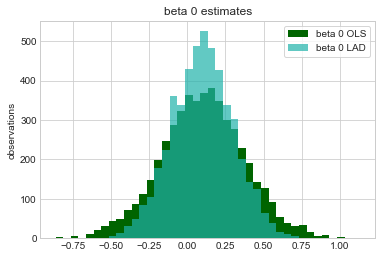

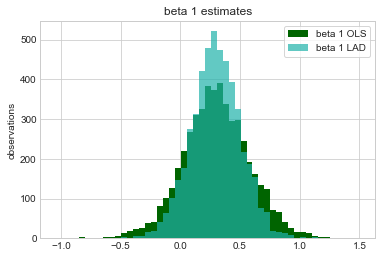

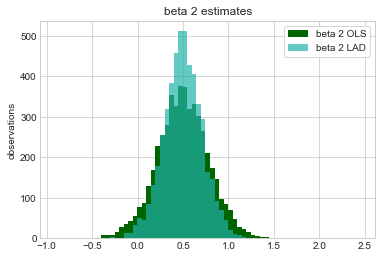

In [18]:
#making sure we have the same amout of estimates from OLS and LAD respectively and then plotting the the 5000 estimates for each of the betas

%matplotlib inline
binwidth=0.05

assert len(b0) == len(b0_lad)
plt.ylabel('observations')
fig1=plt.hist(b0,color='darkgreen', bins=np.arange(min(b0),max(b0) + binwidth, binwidth),label='beta 0 OLS') #setting the same width for bins, so the plot is comparable
fig2=plt.hist(b0_lad,color='lightseagreen',bins=np.arange(min(b0),max(b0) + binwidth, binwidth),label='beta 0 LAD',alpha=0.7)
plt.title('beta 0 estimates')
plt.legend(frameon=True)
plt.show()

assert len(b1) == len(b1_lad)
plt.ylabel('observations')
fig3=plt.hist(b1,color='darkgreen',bins=np.arange(min(b1),max(b1) + binwidth, binwidth),label='beta 1 OLS')
fig4=plt.hist(b1_lad,color='lightseagreen',bins=np.arange(min(b1),max(b1) + binwidth, binwidth),label='beta 1 LAD',alpha=0.7)
plt.title('beta 1 estimates')
plt.legend(frameon=True)
plt.show()

assert len(b2) == len(b2_lad)
plt.ylabel('observations')
fig5=plt.hist(b2,color='darkgreen',bins=np.arange(min(b2),max(b2) + binwidth, binwidth),label='beta 2 OLS')
fig6=plt.hist(b2_lad,color='lightseagreen',bins=np.arange(min(b2),max(b2) + binwidth, binwidth),label='beta 2 LAD', alpha=0.7)
plt.title('beta 2 estimates')
plt.legend(frameon=True)
plt.show()

In the above plot, it becomes clear that both OLS and LAD are unbiased estimators, since they are both concentrated on the true mean. Furthermore, we see that LAD has a lower variance than OLS for all three betas. OLS is usually the estimator with the lowest variance, but since our data follows a fat tail distribution, LAD appears to exhibit lower variance. This makes LAD the preferred estimator. 

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [19]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

First, we define the function for $v_2$, after which we call a solver-function, looping over given values for the two independent variables, $m_2$ and $d$, returning given $v_2$- and $c^*$-values for given parameters of the model, after maximizing the utility function over $c$.

In [20]:
def v2(m2,d,c,chi,alpha,rho):
    x = m2 - c
    return ((c**alpha * (d + chi*(m2-c))**(1-alpha))**(1-rho))/(1-rho)

In [21]:
def solve_v2(chi,alpha,rho):
    N=100
    shape_tuple = (N,N)
    v2_vec_sol = np.empty(shape_tuple)
    c_vec_sol = np.empty(shape_tuple)    
    x_vec_sol = np.empty(shape_tuple)

    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):
            obj = lambda c: -v2(m2,d,c,chi,alpha,rho)
            x0 = m2/2
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=(1e-8,m2))

            v2_vec_sol[i,j] = -result.fun
            c_vec_sol[i,j] = result.x
            x_vec_sol[i,j] = m2 - c_vec_sol[i,j]
        
    return m2_vec, d_vec, v2_vec_sol, c_vec_sol, x_vec_sol

m2_vec, d_vec, v2_vec_sol, c_vec_sol, x_vec_sol = solve_v2(chi,alpha,rho)

m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

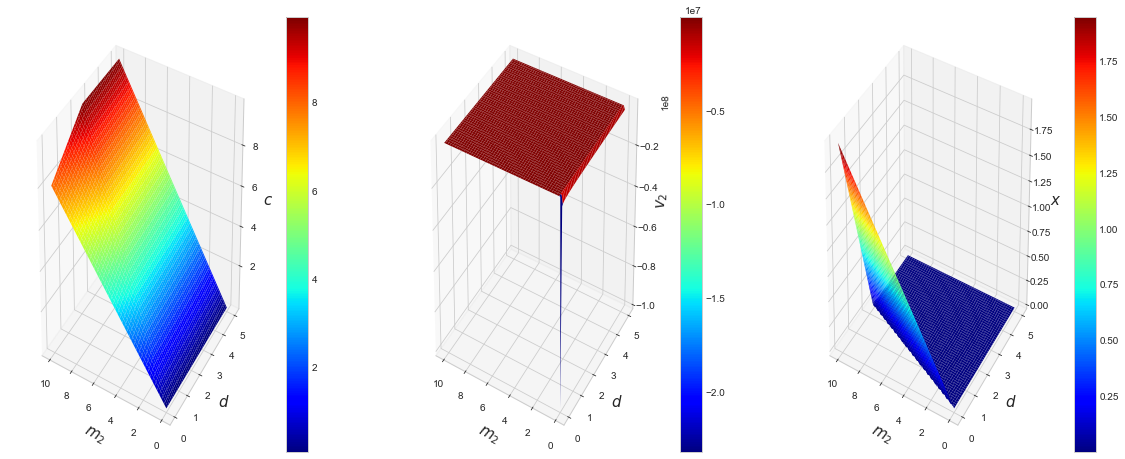

In [22]:
# FIRST FIGURE
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,3,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_vec_sol,cmap=cm.jet)
#ax.set_zlim(0,2)

# adding labels
ax.set_xlabel('$m_2$', fontsize = 15)
ax.set_ylabel('$d$', fontsize = 15)
ax.set_zlabel('$c$', fontsize = 15)

#ax.set_zlim(1,10)
# inverting xaxis
ax.invert_xaxis()
#ax.invert_zaxis()
#ax.invert_yaxis()
fig.colorbar(cs);

#SECOND FIGURE:
ax = fig.add_subplot(1,3,2,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_vec_sol,cmap=cm.jet)

ax.set_xlabel('$m_2$', fontsize = 15)
ax.set_ylabel('$d$', fontsize = 15)
ax.set_zlabel('$v_2$', fontsize = 15)

ax.invert_xaxis()
#ax.invert_zaxis()
#ax.invert_yaxis()


# e. add colorbar
fig.colorbar(cs);

#THIRD FIGURE:
ax = fig.add_subplot(1,3,3,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,x_vec_sol,cmap=cm.jet)

ax.set_xlabel('$m_2$', fontsize = 15)
ax.set_ylabel('$d$', fontsize = 15)
ax.set_zlabel('$x$', fontsize = 15)

ax.invert_xaxis()
#ax.invert_zaxis()
#ax.invert_yaxis()


# e. add colorbar
fig.colorbar(cs);

Firstly, we see a negative $v_2$-function, due to $\rho > 1$, giving negative utility in period 2. We see that the utility in the second period is zero when the consumer maximizes utility. Secondly, we see an increasing optimal consumption in $m_2$, while it is rrelatively constant in $d$ due to the two being independent. Lastly, we find that $x$ increases in $m_2$ and $d$, as more money leads to an increase in extra durable consumption, while an increase in 'normal' durable consumption leads to a decrease. 

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

First, we define our $v_1$-function as the simple average over the different cases for $y$. This is directly related to the $v_2$-function, but as we want to make sure, that we're able to pull values from all of $m_2, d \in R^2$, instead of just the earlier realized values hereof, we need to use an interpolation. 

Second, we call the solver, looping over values for $m_1$, returning the $v_1$-function maximized with respect to $d$. Before calling, we define the interpolation of the $v_2$-function from the existing values herefor and grid of independent values. 

In [23]:
def v1(m1,d,beta,Delta,v2_interp):
    a = m1 - d

    m2_low = (1+r)*a + (1-Delta)
    v2_low = v2_interp([m2_low,d])[0]

    m2_mid = (1+r)*a + 1
    v2_mid = v2_interp([m2_mid,d])[0]

    m2_high = (1+r)*a + (1+Delta)
    v2_high = v2_interp([m2_high,d])[0]

    v2 = np.mean([v2_low,v2_mid,v2_high])
    return beta*v2


In [24]:
def solve_v1(beta,Delta,v2_interp):
    v1_vec = np.empty(100)
    d_sol_vec = np.empty(100)

    for i,m1 in enumerate(m1_vec):
        obj = lambda d: -v1(m1,d,beta,Delta,v2_interp)
        x0 = m1/2
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=(1e-8,m1))

        v1_vec[i] = -result.fun
        d_sol_vec[i] = result.x

    return v1_vec, d_sol_vec, m1_vec

v2_interp = interpolate.RegularGridInterpolator([m2_vec,d_vec],v2_vec_sol,bounds_error=False,fill_value=None)

v1_vec, d_sol_vec, m1_vec = solve_v1(beta,Delta,v2_interp)


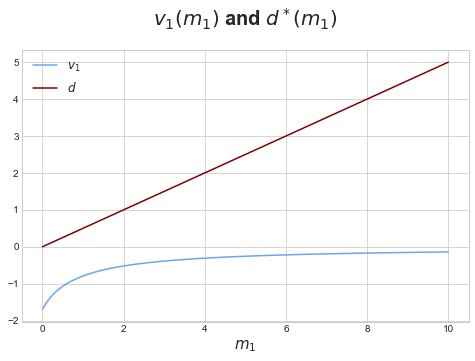

In [25]:
fig, ax1 = plt.subplots(figsize=(8,5))
plt.title('$v_1(m_1)$ and $d^*(m_1)$',fontsize=20,weight='bold',pad=23)
goldman_blue = '#64a8f0'
plt.plot(m1_vec,v1_vec, label = '$v_1$', c=goldman_blue)
plt.plot(m1_vec,d_vec, label = '$d$', c='maroon')

plt.xlabel('$m_1$',fontsize=15)

plt.legend(frameon=False,fontsize=12)

Again, we see that the utility-function is negative, however increasing in the amount of money allocated in period 1. $d$ is monotonically increasing. 

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [26]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

First, we define the $w$-function. Second, we define the v_0-function. This is set to return three values; one for each case of z, as well as an array of both. Third, we run a loop over the given values for $m_0$ and $d_0$, calling the function, in which $w$ is evaluated in $m_0$ in place for $a$, as stated by the question. This loop is set to return the $z_0$-value IF this is the maximizing value (that is, the consumer sticks with what she has), otherwise zero. Thus, the return is the value of the function in the cases, where the consumer does not adjust. We see, that this is the case for all received values.

In [27]:
def w(a,d,beta,Delta,v2_interp):
    m2_low = (1+r)*a + (1-Delta)
    v2_low = v2_interp([m2_low,d])[0]

    m2_mid = (1+r)*a+1
    v2_mid = v2_interp([m2_mid,d])[0]

    m2_high = (1+r)*a + (1+Delta)
    v2_high = v2_interp([m2_high,d])[0]

    v2 = np.mean([v2_low,v2_mid,v2_high])
    return beta*v2

In [28]:
def v0(beta,v2_interp,m0,d0,Lambda,Delta):
    #z0 = beta*v2_interp([m0,d0])[0]
    z0 = w(m0,d0,beta,Delta,v2_interp)
    m_z1 = m0 + (1-Lambda)*d0
    z1 = v1(m_z1,d0,beta,Delta,v2_interp)
    z_vec = np.array([z0,z1])
    #return np.amax(z_vec)
    return z0, z1, z_vec

v0(beta,v2_interp,5,6,Lambda,Delta)

(-0.1552660323383249, -0.1859382538461444, array([-0.15526603, -0.18593825]))

In [29]:
N=100
shape_tuple = (N,N) 
z_sol = np.empty(shape_tuple)

for i,m0 in enumerate(m0_vec):
    for j,d0 in enumerate(d0_vec):
        if v0(beta,v2_interp,m0,d0,Lambda,Delta)[0] == np.amax(v0(beta,v2_interp,m0,d0,Lambda,Delta)[2]):
            z_sol[i,j] = v0(beta,v2_interp,m0,d0,Lambda,Delta)[0]
        else: 
            z_sol[i,j] = 0

m0_grid,d0_grid = np.meshgrid(m0_vec,d0_vec,indexing='ij')

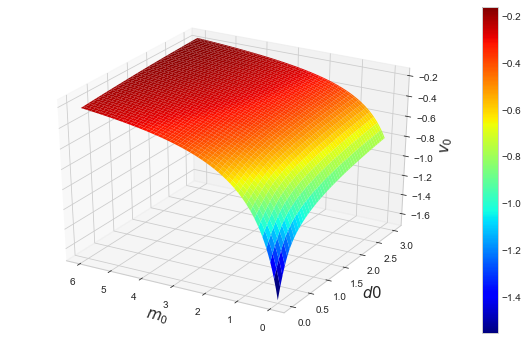

In [30]:
# FIGURE

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m0_grid,d0_grid,z_sol,cmap=cm.jet)
#ax.set_zlim(0,2)

# adding labels
ax.set_xlabel('$m_0$', fontsize = 15)
ax.set_ylabel('$d0$', fontsize = 15)
ax.set_zlabel('$v_0$', fontsize = 15)

#ax.set_zlim(1,10)
# inverting xaxis
ax.invert_xaxis()
#ax.invert_zaxis()
#ax.invert_yaxis()
fig.colorbar(cs);

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

We set up the optimizer-algorithm, following the steps specified above.

In [31]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    """
    Args:
        f: Function, called in the test case below
        x0: Initial guess
        epsilon: Tolerance
        Theta: Scale factor
        Delta: Change
        max_iter: Upper bound for iterations, stops the function from running eternally.
    Returns:
        x: Two-dimensional vector of solutions
        n: Number of iterations made

    """
    # 2. Initializing the two-dimensional function:
    x = x0
    fx = f(x0)
    n = 1

    # Iterating:
    while n < max_iter:
        x_prev = x
        fx_prev = fx

        # 3. Defining the Jacobian:
        jac_1 = f(x_prev + np.array([Delta,0])) - f(x_prev)
        jac_2 = f(x_prev + np.array([0,Delta])) - f(x_prev)
        Jacobian = 1/Delta * np.array([jac_1,jac_2])

        # 4. Stopping if value is less than tolerance:
        if np.amax(Jacobian) < epsilon:
            break

        # 5. Setting theta-value
        theta = Theta

        # 6. Setting f-value
        fx = f(x_prev - theta*Jacobian)

        # 7-8. Reiterating over theta until value of function decreases:
        while fx >= f(x_prev):
            theta = theta/2
            fx = f(x_prev - theta*Jacobian)

        # 9. Setting new x:
        x = x_prev - theta*Jacobian

        # 10. Setting new n:
        n += 1
    return x,n


**Test case:**

In [32]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 306 iterations


## Graphing:

Here, we are defining the function again, just having two specific dimensions instead of one vector, so Matplotlib understands the code.

Then, we graph our findings:

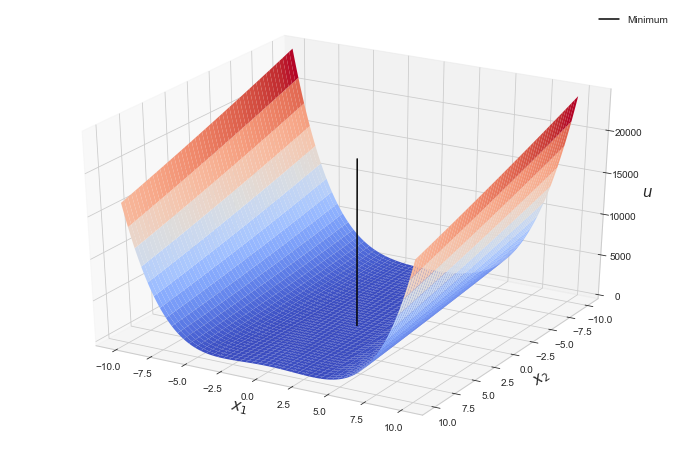

In [33]:
def rosen2(x1,x2):
    return (1.0-x1)**2+2*(x2-x1**2)**2

# a. grids
x1_vec = np.linspace(-10,10,500)
x2_vec = np.linspace(-10,10,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
rosen_grid = rosen2(x1_grid,x2_grid)


# FIGURE
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot3D(np.linspace(1,1.00001,100),np.linspace(1,1.001,100),np.linspace(0,20000,100),c='black',label='Minimum')

ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.coolwarm,linewidth=0,zorder=0)

# adding labels
ax.set_xlabel('$x_1$', fontsize = 15)
ax.set_ylabel('$x_2$', fontsize = 15)
ax.set_zlabel('$u$', fontsize = 15)

# inverting xaxis
ax.invert_yaxis()
#inverting xaxis()


plt.legend()

# e. add colorbar

In [34]:
type(x1_grid)

numpy.ndarray